ResNet50 model 

In [82]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import numpy as np 
import pandas as pd 
import torch 
from PIL import Image
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from torchvision.models.resnet import resnet18
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision.transforms import ToTensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
with torch.no_grad():
    torch.cuda.empty_cache()

In [83]:
import art
from art import attacks 
from art.attacks.evasion import FastGradientMethod, DeepFool, CarliniL0Method, BasicIterativeMethod
from art.estimators.classification import PyTorchClassifier
from art.defences.trainer import AdversarialTrainer

In [84]:
device

device(type='cuda')

In [85]:
# defining hyperparameters  
epochs = 30  #the nn will train 29 times 

learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 64 
classes = 43 
img_size = 32
random_seed = 42

In [86]:
# transforms = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.3403, 0.3121, 0.3214),
#                         (0.2724, 0.2608, 0.2669))
# ])


#set 1
# transforms = transforms.Compose([
#     transforms.Resize((32, 32)),
#      transforms.ToTensor(),
# transforms.Normalize((0.3403, 0.3121, 0.3214),
#                         (0.2724, 0.2608, 0.2669)),
#     transforms.RandomRotation(degrees = (0,1))  

#  ])

# #set 2
# transforms = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(),
#     transforms.GaussianBlur(kernel_size = (5,9)),
# ])

# #set 3
# transforms = transforms.Compose([
#     transforms.ColorJitter(brightness = .5, hue = .3),
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.3403, 0.3121, 0.3214),
#                          (0.2724, 0.2608, 0.2669)),
#     transforms.GaussianBlur(kernel_size = (5,9)),
#     transforms.RandomRotation(degrees = (0, 1))
# ])


# #set 4
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                         (0.2724, 0.2608, 0.2669)),
    transforms.ElasticTransform(alpha = 1.0)          # to re-create rainy weather conditions 
]) 


In [87]:
test_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [88]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset
    global base_dataset
    base_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'train', transform=transforms, download=True)

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset, train_dataset
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7f2e08689a90>, <torch.utils.data.dataloader.DataLoader object at 0x7f2e3bc47640>)


In [89]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [90]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [91]:
# train function

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [92]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat= model(X)    # predicted
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [93]:
# training function
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [94]:
model = resnet18(pretrained = False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 43)
model = model.to(device)

In [95]:

torch.manual_seed(random_seed)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


14:51:11 --- Epoch: 0	Train loss: 1.5748	Valid loss: 0.6200	Train accuracy: 88.80	Valid accuracy: 84.05
14:52:04 --- Epoch: 1	Train loss: 0.3191	Valid loss: 0.2932	Train accuracy: 96.40	Valid accuracy: 91.93
14:52:57 --- Epoch: 2	Train loss: 0.0887	Valid loss: 0.1908	Train accuracy: 98.48	Valid accuracy: 94.59
14:53:49 --- Epoch: 3	Train loss: 0.0466	Valid loss: 0.1929	Train accuracy: 98.29	Valid accuracy: 94.22
14:54:42 --- Epoch: 4	Train loss: 0.0407	Valid loss: 0.2122	Train accuracy: 97.80	Valid accuracy: 93.60
14:55:34 --- Epoch: 5	Train loss: 0.0445	Valid loss: 0.1516	Train accuracy: 99.20	Valid accuracy: 95.63
14:56:27 --- Epoch: 6	Train loss: 0.0384	Valid loss: 0.1521	Train accuracy: 98.62	Valid accuracy: 95.21
14:57:20 --- Epoch: 7	Train loss: 0.0270	Valid loss: 0.1616	Train accuracy: 98.94	Valid accuracy: 95.50
14:58:13 --- Epoch: 8	Train loss: 0.0404	Valid loss: 0.1038	Train accuracy: 99.54	Valid accuracy: 97.20
14:59:05 --- Epoch: 9	Train loss: 0.0306	Valid loss: 0.1248	Trai

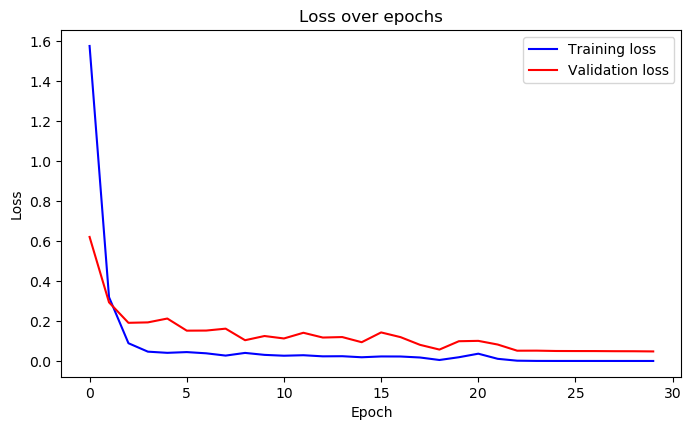

In [96]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

In [ ]:
torch.save(model.state_dict(), "resnet18.pt")

In [14]:
model.load_state_dict(torch.load("resnet18.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# DF attack 

In [97]:
# We wrap our model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
    # model=WrappedModel(),
    model=model,
    clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
    loss=criterion,  # defined above
    optimizer=optimizer,  # defined above
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
)

 # CHANGE output to specific set zodat je ze kan toevoegen in één graph

In [27]:
plot_output_base = []
iterations = 10
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    # attack = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    # attack = DeepFool(classifier= classifier, max_iter= i+1, verbose = False, batch_size= 1)
    success_rates = []
    for j, (image, true_label) in enumerate(test_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy =  np.float32(image)
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            success_rates.append(True)
        else:
            success_rates.append(False)
        # success_rates.append(success)
        if j > 20:
            break
    ASR = success_rates.count(True) / len(success_rates)
    accuracy_score = (1-ASR) 
    plot_output_base.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print("Average Success Rate: {:.2f}%".format(ASR), plot_output_base)

Average Success Rate: 0.82% [(0, 1.0), (1, 0.5909090909090908), (2, 0.2727272727272727), (3, 0.18181818181818177), (4, 0.18181818181818177), (5, 0.18181818181818177), (6, 0.18181818181818177), (7, 0.18181818181818177), (8, 0.18181818181818177), (9, 0.18181818181818177)]


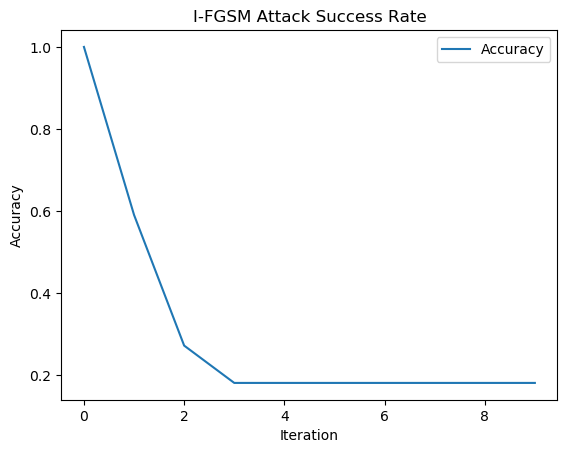

In [100]:
# Plot the success rate over
x = [p[0] for p in plot_output_base]
y = [p[1] for p in plot_output_base]
# Plot the success rate over
plt.plot(x, y, label = "Accuracy")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('I-FGSM Attack Success Rate')
plt.legend(loc='upper right')
plt.show()

In [37]:
plot_output_set1 = []
iterations = 10
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    # attack = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    # attack = DeepFool(classifier= classifier, max_iter= i+1, verbose = False, batch_size= 1)
    success_rates = []
    for j, (image, true_label) in enumerate(test_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy =  np.float32(image)
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            success_rates.append(True)
        else:
            success_rates.append(False)
        # success_rates.append(success)
        if j > 20:
            break
    ASR = success_rates.count(True) / len(success_rates)
    accuracy_score = (1-ASR) 
    plot_output_set1.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print("Average Success Rate: {:.2f}%".format(ASR), plot_output_set1)

Average Success Rate: 0.77% [(0, 1.0), (1, 0.7727272727272727), (2, 0.31818181818181823), (3, 0.2272727272727273), (4, 0.2272727272727273), (5, 0.2272727272727273), (6, 0.2272727272727273), (7, 0.2272727272727273), (8, 0.2272727272727273), (9, 0.2272727272727273)]


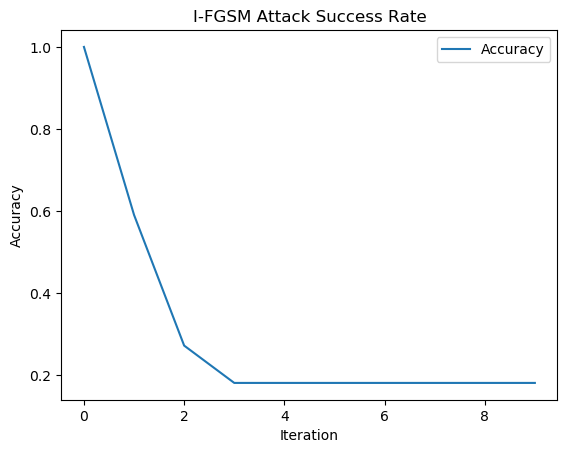

In [101]:
x1 = [p[0] for p in plot_output_set1]
y1 = [p[1] for p in plot_output_set1]
# Plot the success rate over
plt.plot(x, y, label = "Accuracy")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('I-FGSM Attack Success Rate')
plt.legend(loc='upper right')
plt.show()

In [61]:
plot_output_set2 = []
iterations = 10
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    # attack = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    # attack = DeepFool(classifier= classifier, max_iter= i+1, verbose = False, batch_size= 1)
    success_rates = []
    for j, (image, true_label) in enumerate(test_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy =  np.float32(image)
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            success_rates.append(True)
        else:
            success_rates.append(False)
        # success_rates.append(success)
        if j > 20:
            break
    ASR = success_rates.count(True) / len(success_rates)
    accuracy_score = (1-ASR) 
    plot_output_set2.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print("Average Success Rate: {:.2f}%".format(ASR), plot_output_set2)

Average Success Rate: 0.82% [(0, 1.0), (1, 0.2272727272727273), (2, 0.13636363636363635), (3, 0.18181818181818177), (4, 0.18181818181818177), (5, 0.18181818181818177), (6, 0.13636363636363635), (7, 0.18181818181818177), (8, 0.13636363636363635), (9, 0.18181818181818177)]


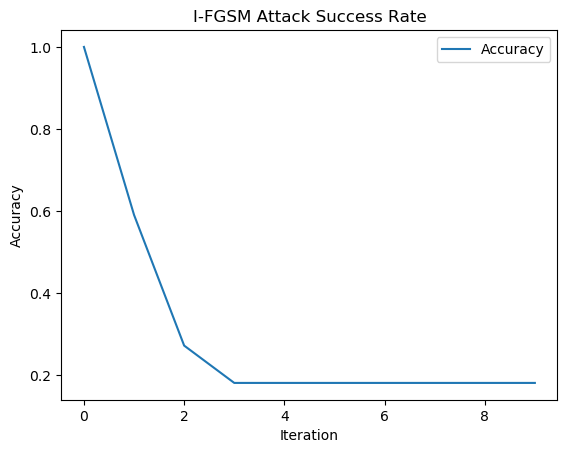

In [102]:
x2 = [p[0] for p in plot_output_set2]
y2 = [p[1] for p in plot_output_set2]
# Plot the success rate over
plt.plot(x, y, label = "Accuracy")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('I-FGSM Attack Success Rate')
plt.legend(loc='upper right')
plt.show()

In [80]:
plot_output_set3 = []
iterations = 10
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    # attack = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    # attack = DeepFool(classifier= classifier, max_iter= i+1, verbose = False, batch_size= 1)
    success_rates = []
    for j, (image, true_label) in enumerate(test_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy =  np.float32(image)
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            success_rates.append(True)
        else:
            success_rates.append(False)
        # success_rates.append(success)
        if j > 20:
            break
    ASR = success_rates.count(True) / len(success_rates)
    accuracy_score = (1-ASR) 
    plot_output_set3.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print("Average Success Rate: {:.2f}%".format(ASR), plot_output_set3)

Average Success Rate: 0.77% [(0, 1.0), (1, 0.6818181818181819), (2, 0.31818181818181823), (3, 0.09090909090909094), (4, 0.13636363636363635), (5, 0.13636363636363635), (6, 0.18181818181818177), (7, 0.13636363636363635), (8, 0.13636363636363635), (9, 0.2272727272727273)]


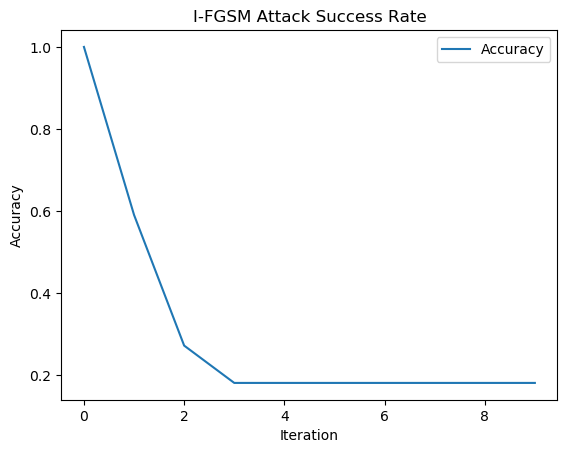

In [103]:
x3 = [p[0] for p in plot_output_set3]
y3 = [p[1] for p in plot_output_set3]
# Plot the success rate over
plt.plot(x, y, label = "Accuracy")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('I-FGSM Attack Success Rate')
plt.legend(loc='upper right')
plt.show()

In [106]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [98]:
plot_output_set4 = []
iterations = 10
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    # attack = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    # attack = DeepFool(classifier= classifier, max_iter= i+1, verbose = False, batch_size= 1)
    success_rates = []
    for j, (image, true_label) in enumerate(test_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy =  np.float32(image)
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            success_rates.append(True)
        else:
            success_rates.append(False)
        # success_rates.append(success)
        if j > 20:
            break
    ASR = success_rates.count(True) / len(success_rates)
    accuracy_score = (1-ASR) 
    plot_output_set4.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print("Average Success Rate: {:.2f}%".format(ASR), plot_output_set4)

Average Success Rate: 0.82% [(0, 1.0), (1, 0.5909090909090908), (2, 0.2727272727272727), (3, 0.13636363636363635), (4, 0.18181818181818177), (5, 0.13636363636363635), (6, 0.13636363636363635), (7, 0.13636363636363635), (8, 0.13636363636363635), (9, 0.18181818181818177)]


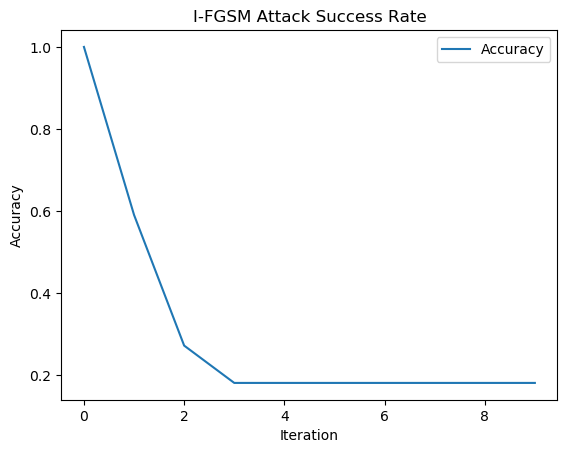

In [104]:
x4 = [p[0] for p in plot_output_set4]
y4 = [p[1] for p in plot_output_set4]
# Plot the success rate over
plt.plot(x, y, label = "Accuracy")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('I-FGSM Attack Success Rate')
plt.legend(loc='upper right')
plt.show()

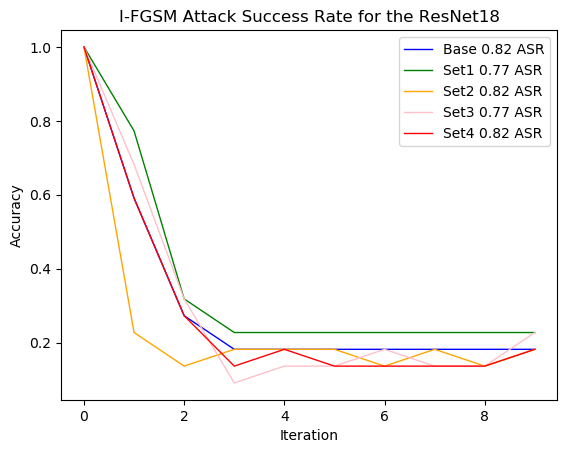

In [106]:

# Set the x axis label of the current axis.
plt.xlabel('Iteration')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy')
# Set a title 
plt.title('I-FGSM Attack Success Rate for the ResNet18')
# Display the figure.
plt.plot(x,y, color='blue', linewidth = 1,  label = 'Base 0.82 ASR')
plt.plot(x1,y1, color='green', linewidth = 1,  label = 'Set1 0.77 ASR')
plt.plot(x2,y2, color='orange', linewidth = 1,  label = 'Set2 0.82 ASR')
plt.plot(x3,y3, color='pink', linewidth =1,  label = 'Set3 0.77 ASR')
plt.plot(x4,y4, color='red', linewidth = 1,  label = 'Set4 0.82 ASR')

# show a legend on the plot
plt.legend()
plt.show()

In [110]:
tot14 = 0

for j, (a, b) in enumerate(train_dataset):
    if b == 14:
        tot14 += 1
    if j >100:
         break


In [111]:
print(len(train_dataset))

21312
